In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/IssuesManagement

/content/drive/.shortcut-targets-by-id/1Hgps4QuC_8w15htjlDJJFgm2WyvBtk5Y/IssuesManagement


In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
stopWords = set(stopwords.words('english'))
stopWords = stopWords.union(set(['com', 'org', 'java']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import csv
import torch
from tqdm import tqdm
p = PorterStemmer()
import pandas as pd

In [5]:
PROJECT_NAME = "FLUME"

TEXT_FEATURES = ["title", "description", "summary"]
ADDING_TIME_FEATURES = ["CC", "CU"]

MAXLEN = 256
MODEL_NAME = "LSTM"
EMBEDDING_METHOD = "GloVe"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load data

In [6]:
train_links = pd.read_csv(
    f"data/{PROJECT_NAME}/train_links.csv", keep_default_na=False)
train_links['label'] = train_links['label'].map(lambda x: int(x!=0))
issues = pd.read_csv(
    f"data/{PROJECT_NAME}/preprocessed_attributes.csv", index_col="key")
issues['created'] = pd.to_datetime(issues['created'], utc=True)
issues['updated'] = pd.to_datetime(issues['updated'], utc=True)
issues = issues.fillna(" ")
first_feature = TEXT_FEATURES[0]
issues["text"] = issues[first_feature]
if len(TEXT_FEATURES)>1:
  for feature in TEXT_FEATURES[1:]:
    issues["text"] = issues["text"] + " " + issues[feature]

In [7]:
text_list = list(issues["text"].values)

In [8]:
with open("textual_data.csv", "w") as f:
  wr = csv.writer(f)
  textual_data = []
  for text in tqdm(text_list):
    text = text.lower()
    temp = []
    for word in word_tokenize(text):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)
    wr.writerow(temp)

100%|██████████| 3455/3455 [00:05<00:00, 576.74it/s]


In [9]:
import gensim
EMBEDDING_DIM = 20

In [10]:
model_CBOW = gensim.models.Word2Vec(textual_data, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)

In [11]:
model_CBOW.save("word2vec.model")

In [12]:
from gensim.models import Word2Vec
model_CBOW = Word2Vec.load("word2vec.model")

In [13]:
import pickle
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Reshape
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model
from tensorflow.keras.initializers import Constant
from keras.layers import Layer
from tensorflow.keras.layers import Embedding
import keras
import tensorflow.keras.backend as K
import random
from keras.callbacks import EarlyStopping
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.utils.class_weight
from sklearn import metrics

import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def dice_loss (y_true, y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = y_true_f * y_pred_f
  score = (2 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum (y_pred_f) + smooth)
  return 1 - score
def bce_loss (y_true, y_pred):
  # return bce(y_true, y_pred) + dice_loss(y_true, y_pred)
  return bce(y_true, y_pred)

In [15]:
def DCCNN_Model(input_shape):
    X_input = Input(shape=input_shape)

    X_1 = Conv2D(100, kernel_size=(1,20), strides=(1,1), activation='relu')(X_input)
    X_1 = layers.BatchNormalization(axis=-1)(X_1)
    X_1 = Reshape((300,100,1))(X_1)


    X_1_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_1)
    X_1_1 = layers.BatchNormalization(axis=-1)(X_1_1)
    X_1_1 = MaxPooling2D(pool_size=(300,1),padding='valid')(X_1_1)
    X_1_1 = Flatten()(X_1_1)
    X_1_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_1)
    X_1_2 = layers.BatchNormalization(axis=-1)(X_1_2)
    X_1_2 = MaxPooling2D(pool_size=(299,1),padding='valid')(X_1_2)
    X_1_2 = Flatten()(X_1_2)
    X_1_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_1)
    X_1_3 = layers.BatchNormalization(axis=-1)(X_1_3)
    X_1_3 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_1_3)
    X_1_3 = Flatten()(X_1_3)

    X_1 = layers.Concatenate(axis=-1)([X_1_1,X_1_2])
    X_1 = layers.Concatenate(axis=-1)([X_1,X_1_3])

    X_2 = Conv2D(100, kernel_size=(2,20), strides=(1,1),activation='relu')(X_input)
    X_2 = layers.BatchNormalization(axis=-1)(X_2)
    X_2 = Reshape((299,100,1))(X_2)

    X_2_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_2)
    X_2_1 = layers.BatchNormalization(axis=-1)(X_2_1)
    X_2_1 = MaxPooling2D(pool_size=(299,1),padding='valid')(X_2_1)
    X_2_1 = Flatten()(X_2_1)
    X_2_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_2)
    X_2_2 = layers.BatchNormalization(axis=-1)(X_2_2)
    X_2_2 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_2_2)
    X_2_2 = Flatten()(X_2_2)
    X_2_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_2)
    X_2_3 = layers.BatchNormalization(axis=-1)(X_2_3)
    X_2_3 = MaxPooling2D(pool_size=(297,1),padding='valid')(X_2_3)
    X_2_3 = Flatten()(X_2_3)

    X_2 = layers.Concatenate(axis=-1)([X_2_1,X_2_2])
    X_2 = layers.Concatenate(axis=-1)([X_2,X_2_3])

    X_3 = Conv2D(100, kernel_size=(3,20), strides=(1,1),activation='relu')(X_input)
    X_3 = layers.BatchNormalization(axis=-1)(X_3)
    X_3 = Reshape((298,100,1))(X_3)

    X_3_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_3)
    X_3_1 = layers.BatchNormalization(axis=-1)(X_3_1)
    X_3_1 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_3_1)
    X_3_1 = Flatten()(X_3_1)
    X_3_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_3)
    X_3_2 = layers.BatchNormalization(axis=-1)(X_3_2)
    X_3_2 = MaxPooling2D(pool_size=(297,1),padding='valid')(X_3_2)
    X_3_2 = Flatten()(X_3_2)
    X_3_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_3)
    X_3_3 = layers.BatchNormalization(axis=-1)(X_3_3)
    X_3_3 = MaxPooling2D(pool_size=(296,1),padding='valid')(X_3_3)
    X_3_3 = Flatten()(X_3_3)

    X_3 = layers.Concatenate(axis=-1)([X_3_1,X_3_2])
    X_3 = layers.Concatenate(axis=-1)([X_3,X_3_3])

    X = layers.Concatenate(axis=-1)([X_1,X_2])
    X = layers.Concatenate(axis=-1)([X,X_3])

    X = Dropout(0.6)(X)
    X = Dense(300, activation='relu')(X)
    X = layers.BatchNormalization(axis=-1)(X)


    X = Dropout(0.4)(X)
    X = Dense(100, activation='relu')(X)
    X = layers.BatchNormalization(axis=-1)(X)


    X = Dropout(0.4)(X)
    Y = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = Y, name='CNN_Model')

#     print(model.summary())

    return model

def train_model(df_train):
    # tf.set_random_seed(1)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    matrix_train, tags_train = get_matrices(df_train)

    data_train = []
    label_train = []

    data_train = np.array(matrix_train)
    label_train = np.array(tags_train)

    index = [i for i in range(len(data_train))]
    random.shuffle(index)
    data_train = data_train[index]
    label_train = label_train[index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=2)

    dccnnModel = DCCNN_Model((300, 20, 2))
    dccnnModel.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=bce_loss, metrics=['accuracy'])
    hist = dccnnModel.fit(x=data_train, y=label_train, batch_size=64, epochs=48, validation_split=0.3, callbacks=[early_stopping], verbose=1)

    plot_history(hist)

    K.clear_session()

    return dccnnModel

def predict_model(model, df_test):
    matrix_test, tags_test = get_matrices(df_test)

    data_test = []
    label_test = []

    data_test = np.array(matrix_test)
    label_test = np.array(tags_test)

    ## Get predictions
    preds = model.predict(np.array(data_test))
    roundelt_preds = np.round(preds).astype(int)

    return preds, roundelt_preds

In [16]:
def get_matrices(df_set):
    c=0
    matrix = []
    tags = []
    for i in range(len(df_set)): #contains preprocessed bug reports
        m1 = np.zeros((300,20))
        m2 = np.zeros((300,20))
        count = 0
        line1 = df_set['text_1'].iloc[i]
        line2 = df_set['text_2'].iloc[i]
        words1 = str(line1).split(' ')
        words2 = str(line2).split(' ')
        for word in words1:
    #         print(word)
            if count<300:
                if word in model_CBOW.wv:
                    m1[count,:]=model_CBOW.wv[word]
                    count+=1
                else:
                    count+=1
        count = 0
        for word in words2:
    #         print(word)
            if count<300:
                if word in model_CBOW.wv:
                    m2[count,:]=model_CBOW.wv[word]
                    count+=1
                else:
                    count+=1
        tag = df_set['label'].iloc[i]
        tags.append(tag)
        m1 = m1.reshape(300,20,1)
        m2 = m2.reshape(300,20,1)
        c+=1
        matrix_temp=np.append(m1,m2,axis=2)
        matrix.append(matrix_temp)

    print(c)

    return matrix, tags

In [17]:
print("Creating functions.")
def plot_history(history):
#     keys = history.history.keys()
    for i in list(history.history)[0:2]:
        print(i)
        # list all data in history
        # summarize history for accuracy
        plt.plot(history.history[i])
        plt.plot(history.history['val_'+i])
        plt.title('model '+ i)
        plt.ylabel(i)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Creating functions.


In [18]:
train_data = pd.DataFrame(columns=["text_1", "text_2", "label"])
texts_1 = issues["text"].loc[train_links.key_1.values].values
texts_2 = issues["text"].loc[train_links.key_2.values].values
labels = train_links.label.values
train_data["text_1"] = texts_1
train_data["text_2"] = texts_2
train_data["label"] = labels
train_data

,text_1,text_2,label
0,flume 8 release release 8 umbrella issue flume...,revert log4j upgrade 9 branch revert log4j u...,0
1,flume shall inject default event headers event...,allow custom flume outputformats via plugin in...,0
2,remove hadoop profile profile quite painful ma...,source submit event channel doesnot connect si...,0
3,create ng wal component create ng wal component,flow isolation multiple flows case user guide ...,0
4,refactor ng core module move sources channels ...,update releasenotes 8 release update release...,0
...,...,...,...
579877,many approved licenses mvn package fails follo...,generated dist tarball missing flume ng embedd...,0
579878,hdfs sink check file closed retry use new api ...,turn hbase sinks plugins current implementatio...,0
579879,agents end error mode all collectors killed df...,add support monitoring apis add support moni...,0
579880,flume uses jsr 305 annotations without declari...,execsource provide configurable charset charac...,0


In [19]:
train_data_1 = train_data[train_data["label"]==1]
train_data_2 = train_data[train_data["label"]==0]
train_data_2 = train_data_2.sample(len(train_data_1)*3)
train_data = pd.concat([train_data_1, train_data_2])
train_data

,text_1,text_2,label
192,support text output hdfs sink subtask supporti...,support text output flume support text output ...,1
1610,announce release 7 announce release 7,flume 7 release release 7 umbrella issue flume...,1
2862,elasticsearchsink indexnamebuildercontext puta...,hdfs file suffix style index suffix elasticsea...,1
3246,webapps autofindport feature work regression u...,fix rest tests work maven moving maven tests i...,1
3690,add flume morphline solr sink add flume morphl...,add source capable feeding twitter streaming a...,1
...,...,...,...
457625,generated source tarball missing flume ng embe...,create windows service flume fully manageable ...,0
121520,handle offset migration new kafka channel offs...,support defaults inheritance configs proposal ...,0
131368,flume consistently using 70 cpu fairly light o...,based monitoring flume agents hadoop related p...,0
158204,kite datasetsink 0 number progress needed enha...,hdfseventsink option use rawlocalfilesystem du...,0


2240


Epoch 1/48


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 20s 159ms/step - loss: 0.9050 - accuracy: 0.5376 - val_loss: 0.6233 - val_accuracy: 0.7679
Epoch 2/48
25/25 [==============================] - 2s 70ms/step - loss: 0.7758 - accuracy: 0.6052 - val_loss: 0.5660 - val_accuracy: 0.7679
Epoch 3/48
25/25 [==============================] - 2s 68ms/step - loss: 0.6989 - accuracy: 0.6582 - val_loss: 0.5637 - val_accuracy: 0.7679
Epoch 4/48
25/25 [==============================] - 2s 75ms/step - loss: 0.6706 - accuracy: 0.6754 - val_loss: 0.5529 - val_accuracy: 0.7679
Epoch 5/48
25/25 [==============================] - 2s 68ms/step - loss: 0.6305 - accuracy: 0.6926 - val_loss: 0.5402 - val_accuracy: 0.7679
Epoch 6/48
25/25 [==============================] - 2s 75ms/step - loss: 0.6276 - accuracy: 0.7034 - val_loss: 0.5441 - val_accuracy: 0.7679
Epoch 7/48
25/25 [==============================] - 2s 75ms/step - loss: 0.6121 - accuracy: 0.7207 - val_loss: 0.5750 - val_accuracy: 0.7679
Epoch 8/48
25/25 [====

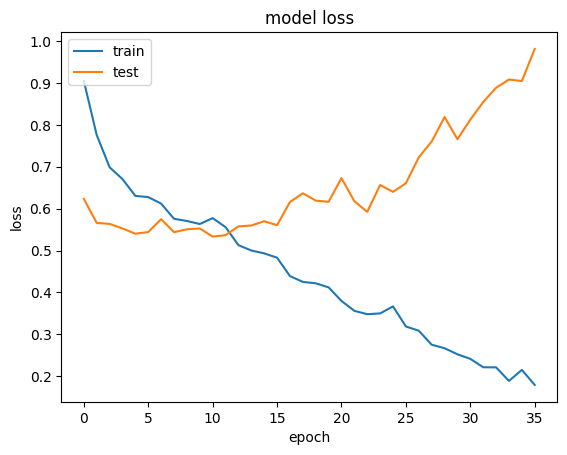

accuracy


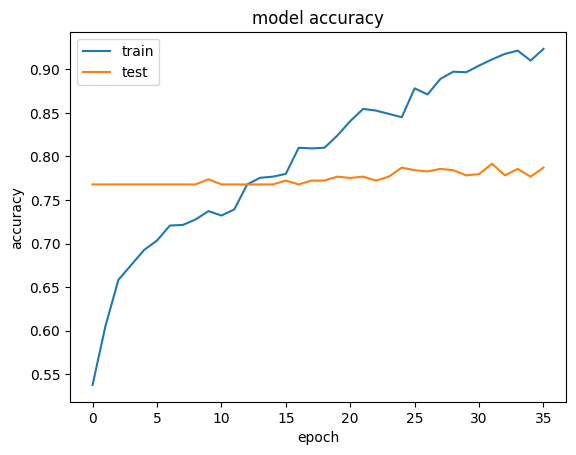

In [20]:
sccnn_model = train_model(train_data)

In [21]:
test_links = pd.read_csv(
    f"data/{PROJECT_NAME}/test_links.csv", keep_default_na=False)
test_links['label'] = test_links['label'].map(lambda x: int(x!=0))

In [22]:
test_data = pd.DataFrame(columns=["text_1", "text_2", "label"])
texts_1 = issues["text"].loc[test_links.key_1.values].values
texts_2 = issues["text"].loc[test_links.key_2.values].values
labels = test_links.label.values
test_data["text_1"] = texts_1
test_data["text_2"] = texts_2
test_data["label"] = labels
test_data

,text_1,text_2,label
0,hbase 98 compatibility addition adding new pro...,support original urls maven build support or...,0
1,groundwork version changes root pom flume root...,finish converting src java slf4j stragglers co...,0
2,implement failover agent would helpful flume n...,testelasticsearchsink shouldindexfiveeventsove...,0
3,change javadoc generation per cve 2013 1571 vu...,surefire 12 cannot run single test windows upg...,0
4,allow compression avro output formats current ...,flume shell script work bin directory go flume...,0
...,...,...,...
496519,add commons io dependency hadoop profile enabl...,occasional multi hour pauses file channel repl...,0
496520,source submit event channel doesnot connect si...,tool script deleting individual message queue ...,0
496521,file descriptor leaks taildirsource taildirsou...,loggersink representation event body useful lo...,0
496522,regex interceptor populate headers using log4j...,upgrade httpclient due cve github com advisori...,0


In [23]:
from torch.utils.data import Dataset,  DataLoader
class TestDataset(Dataset):
    def __init__(self, index_pairs, labels):
        self.index_pairs = index_pairs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
      return [self.index_pairs[idx,0], self.index_pairs[idx,1]], self.labels[idx]

In [24]:
test_dataset = TestDataset(test_data[["text_1", "text_2"]].values, labels)

In [25]:
test_dataloader = DataLoader(test_dataset, batch_size=2048)
len(test_dataloader)

243

In [26]:
pred_proba = torch.tensor([])
for index, i in enumerate(test_dataloader):
  print(index)
  [text_1, text_2], label = i
  subdata = pd.DataFrame({"text_1": text_1, "text_2": text_2, "label": label})
  x, _ = predict_model(sccnn_model, subdata)
  pred_proba=tf.concat([pred_proba, x.reshape(-1)],axis=0)

0
2048
64/64 [==============================] - 1s 11ms/step
1
2048
64/64 [==============================] - 1s 8ms/step
2
2048
64/64 [==============================] - 1s 8ms/step
3
2048
64/64 [==============================] - 1s 8ms/step
4
2048
64/64 [==============================] - 1s 8ms/step
5
2048
64/64 [==============================] - 1s 8ms/step
6
2048
64/64 [==============================] - 1s 9ms/step
7
2048
64/64 [==============================] - 1s 9ms/step
8
2048
64/64 [==============================] - 1s 10ms/step
9
2048
64/64 [==============================] - 1s 8ms/step
10
2048
64/64 [==============================] - 1s 8ms/step
11
2048
64/64 [==============================] - 1s 8ms/step
12
2048
64/64 [==============================] - 1s 8ms/step
13
2048
64/64 [==============================] - 1s 8ms/step
14
2048
64/64 [==============================] - 1s 11ms/step
15
2048
64/64 [==============================] - 1s 8ms/step
16
2048
64/64 [================

In [27]:
pred_s = np.round(pred_proba).astype(int)
y_s = labels
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion maxtrix")
print(confusion_matrix(y_s, pred_s))
print(classification_report(y_s, pred_s, digits= 2))

Confusion maxtrix
[[492001   4300]
 [   171     52]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    496301
           1       0.01      0.23      0.02       223

    accuracy                           0.99    496524
   macro avg       0.51      0.61      0.51    496524
weighted avg       1.00      0.99      1.00    496524



# Recommend

In [28]:
match_test_links = test_links[test_links["label"]!=0]

In [29]:
test_issues = pd.read_csv(f"data/{PROJECT_NAME}/test_issues.csv", index_col="key").index

y_test = []
filter_test_issues = []
for test_issue in tqdm(test_issues):
  filter_links = match_test_links[(match_test_links["key_1"]==test_issue)|(match_test_links["key_2"]==test_issue)]
  if len(filter_links)>0:
    match_issues = set(list(filter_links["key_1"].values) + list(filter_links["key_2"].values))
    match_issues.remove(test_issue)
    y_test.append(list(match_issues))
    filter_test_issues.append(test_issue)
test_issues = filter_test_issues

100%|██████████| 276/276 [00:00<00:00, 1449.86it/s]


In [30]:
len(test_issues)

276

In [51]:
def get_accuracy(pred, gt):
	acc = 0
	for i, item in enumerate(pred):
		if item in gt:
			acc += 1.0
			break
	return acc

def get_MRR(pred, gt):
	mrr = 0
	for i, item in enumerate(pred):
		if item in gt:
			mrr += 1.0/(i+1)
	return mrr

def get_precision_recall(pred, gt):
	right = 0

	for item in gt:
		if item in pred: # relevant
			right+=1

	if len(pred) == 0:
		precision = 0
	else:
		precision = right/len(pred)
	recall = right/len(gt)

	return precision, recall

def get_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def get_f0_5_score(precision, recall):
    beta = 0.5
    if precision + recall == 0:
        return 0
    f0_5_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    return f0_5_score

def get_f2_score(precision, recall):
    beta = 2
    if precision + recall == 0:
        return 0
    f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    return f2_score

def get_metrics(recommend, label):
	acc = 0
	mrr = 0
	precision = 0
	recall = 0
	f1 = 0
	f0_5 = 0
	f2 = 0
	for i in range(0, len(recommend)):
		if len(label[i])!=0:
			acc += get_accuracy(recommend[i], label[i])
			mrr += get_MRR(recommend[i], label[i])
			precision_recall = get_precision_recall(recommend[i], label[i])
			precision += precision_recall[0]
			recall += precision_recall[1]
			f1 = get_f1_score(precision_recall[0], precision_recall[1])
			f0_5 = get_f0_5_score(precision_recall[0], precision_recall[1])
			f2 = get_f2_score(precision_recall[0], precision_recall[1])

	acc = acc/(len(recommend))
	mrr = mrr/(len(recommend))
	precision = precision/(len(recommend))
	recall = recall/(len(recommend))
	f1 = f1/(len(recommend))
	f0_5 = f0_5/(len(recommend))
	f2 = f2/(len(recommend))
	return acc, mrr, precision, recall, f1, f0_5, f2


In [54]:
def get_recommendation(test_issue, issues, test_links):
  all_issues = list(issues.index)
  all_issues.remove(test_issue)

  test_links_1 = pd.DataFrame(
      {"key_1": [test_issue]*len(all_issues), "key_2": all_issues})
  test_links_1["link_id"] = test_links_1["key_1"] + "-" + test_links_1["key_2"]
  test_links_1 = test_links[test_links["link_id"].isin(test_links_1["link_id"].values)]
  pred_proba_1 = [(pred, issue) for pred, issue in zip(test_links_1["proba"].values, test_links_1["key_2"].values)]

  test_links_2 = pd.DataFrame(
      {"key_1": all_issues, "key_2": [test_issue]*len(all_issues)})
  test_links_2["link_id"] = test_links_2["key_1"] + "-" + test_links_2["key_2"]
  test_links_2 = test_links[test_links["link_id"].isin(test_links_2["link_id"].values)]
  pred_proba_2 = [(pred, issue) for pred, issue in zip(test_links_2["proba"].values, test_links_2["key_1"].values)]

  pred_proba_3 = pred_proba_1 + pred_proba_2
  preprocess_pred_proba = {}
  for pred, issue in pred_proba_3:
    if issue not in preprocess_pred_proba:
      preprocess_pred_proba[issue] = pred
    else:
      preprocess_pred_proba[issue] = max(pred, preprocess_pred_proba[issue])
  preprocess_pred_proba = [(pred, issue) for issue, pred in preprocess_pred_proba.items()]

  return [pair[1] for pair in sorted(preprocess_pred_proba, reverse=True)]

def filter_time(issues, test_issue, recommend_issues, days: int):
    cre_1 = issues["created"].loc[[test_issue]*len(recommend_issues)].values
    cre_2 = issues["created"].loc[recommend_issues].values
    cre_cre = np.abs(
        np.array((cre_1-cre_2) / np.timedelta64(1, 'D'), dtype=int))
    recommend_issues = [i for index, i in enumerate(
        recommend_issues) if cre_cre[index] <= days]
    return recommend_issues

In [55]:
pred_proba

<tf.Tensor: shape=(496524,), dtype=float32, numpy=
array([0.00660578, 0.0006397 , 0.08690277, ..., 0.02286254, 0.00054178,
       0.24651442], dtype=float32)>

In [56]:
test_links["link_id"] = test_links["key_1"] + "-" + test_links["key_2"]
test_links["proba"] = pred_proba

In [57]:
recommend_results = []
for test_issue in tqdm(test_issues):
    recommend_results.append(get_recommendation(
        test_issue, issues, test_links))

100%|██████████| 276/276 [00:21<00:00, 13.13it/s]


In [58]:
print("---No filter---")
for k in [1,2,3,5,10]:
  recommend_list = [i[:k] for i in recommend_results]
  acc, mrr, precision, recall, f1, f0_5, f2 = get_metrics(recommend_list, y_test)
  print(f"Top {k}:")
  print(f"Acc = {acc}")
  print(f"MRR = {mrr}")
  print(f"Recall = {recall}")
  print(f"F1 = {f1}")
  print(f"F0.5 = {f0_5}")
  print(f"F2 = {f2}")

---No filter---
Top 1:
Acc = 0.050724637681159424
MRR = 0.050724637681159424
Recall = 0.04830917874396135
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 2:
Acc = 0.08333333333333333
MRR = 0.06884057971014493
Recall = 0.08212560386473429
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 3:
Acc = 0.10144927536231885
MRR = 0.07487922705314007
Recall = 0.1002415458937198
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 5:
Acc = 0.12318840579710146
MRR = 0.07995169082125603
Recall = 0.12198067632850243
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 10:
Acc = 0.15579710144927536
MRR = 0.08481280193236714
Recall = 0.1539855072463768
F1 = 0.0
F0.5 = 0.0
F2 = 0.0


In [59]:
print("---60 days filter---")
filter_recommend_results = []
for test_issue, recommend_issues in zip(test_issues, recommend_results):
    filter_recommend_results.append(
        filter_time(issues, test_issue, recommend_issues, 60))
for k in [1,2,3,5,10]:
  recommend_list = [i[:k] for i in filter_recommend_results]
  acc, mrr, precision, recall, f1, f0_5, f2 = get_metrics(recommend_list, y_test)
  print(f"Top {k}:")
  print(f"Acc = {acc}")
  print(f"MRR = {mrr}")
  print(f"Recall = {recall}")
  print(f"F1 = {f1}")
  print(f"F0.5 = {f0_5}")
  print(f"F2 = {f2}")

print("---30 days filter---")
filter_recommend_results = []
for test_issue, recommend_issues in zip(test_issues, recommend_results):
    filter_recommend_results.append(
        filter_time(issues, test_issue, recommend_issues, 30))
for k in [1,2,3,5,10]:
  recommend_list = [i[:k] for i in filter_recommend_results]
  acc, mrr, precision, recall, f1, f0_5, f2 = get_metrics(recommend_list, y_test)
  print(f"Top {k}:")
  print(f"Acc = {acc}")
  print(f"MRR = {mrr}")
  print(f"Recall = {recall}")
  print(f"F1 = {f1}")
  print(f"F0.5 = {f0_5}")
  print(f"F2 = {f2}")

---60 days filter---
Top 1:
Acc = 0.17753623188405798
MRR = 0.17753623188405798
Recall = 0.17330917874396135
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 2:
Acc = 0.2246376811594203
MRR = 0.2028985507246377
Recall = 0.21739130434782605
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 3:
Acc = 0.23550724637681159
MRR = 0.20652173913043478
Recall = 0.22826086956521738
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 5:
Acc = 0.27898550724637683
MRR = 0.21811594202898552
Recall = 0.268719806763285
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 10:
Acc = 0.34782608695652173
MRR = 0.22666350356567758
Recall = 0.3375603864734299
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
---30 days filter---
Top 1:
Acc = 0.1956521739130435
MRR = 0.1956521739130435
Recall = 0.18961352657004832
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 2:
Acc = 0.2246376811594203
MRR = 0.21195652173913043
Recall = 0.21557971014492752
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 3:
Acc = 0.25
MRR = 0.2216183574879227
Recall = 0.2427536231884058
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Top 5:
Acc = 0.30434782608695654
MRR = 0.23466